In [1]:


import os, sys, time, copy, pickle as pkl
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
output_dir = '/checkpoint/pillutla/pfl/outputs'
output_dir_fed = '/checkpoint/pillutla/pfl/outputs_fed'

In [3]:
def load_pkl(fn):
    if not os.path.isfile(fn):
        return None
    with open(fn, 'rb') as f:
        x = pkl.load(f)
    return x

In [59]:
def make_pers_scatter(out, param, dataset):
    train_sizes, train_metrics, test_sizes, test_metrics = out

    metric_diff_final = [m['accuracy'].values[-1] - m['accuracy'].values[0] for m in test_metrics]
    metric_diff_best = [m['accuracy'].values[1:].max() - m['accuracy'].values[0] for m in test_metrics]

    f, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].scatter(train_sizes, metric_diff_final, alpha=0.2)
    ax[1].scatter(train_sizes, metric_diff_best, alpha=0.2)

    x_max = 10000 if dataset.lower() in ['so', 'stackoverflow', 'stack overflow'] else 400
    for a in ax:
        a.set_xlim((0, x_max))
        a.axhline(y=0, color='black', linestyle='dashed')
        a.set_xlabel('#Train ex. per client', fontsize=18)
        a.set_ylabel(r'$\Delta$Acc. due to pers.', fontsize=18)
    ax[0].set_title('Final iterate', fontsize=18)
    ax[1].set_title('Best along training', fontsize=18)

    f.suptitle(f'{dataset} / {param}', fontsize=19)

    plt.tight_layout()


In [77]:
def make_best_iter_scatter(out, ax, param, dataset):
    train_sizes, train_metrics, test_sizes, test_metrics = out

    best_idxs = [m['accuracy'].values.argmax() for m in test_metrics]
    max_idx_is_final = [int(m['accuracy'].values.argmax() == m.shape[0]) for m in test_metrics]

    ax.scatter(train_sizes, best_idxs, alpha=0.2)


    x_max = 10000 if dataset.lower() in ['so', 'stackoverflow', 'stack overflow'] else 400
    ax.set_xlim((0, x_max))
    ax.set_xlabel('#Train ex. per client', fontsize=12)
    ax.set_ylabel('Epoch with best acc.', fontsize=12)

    ax.set_title(f'{dataset} / {param} / max idx', fontsize=12)



# Personalization Output: Stack Overflow

In [3]:
param_list = [
    "finetune", "finetune_inp_layer", "finetune_out_layer",
    "finetune_tr_layer_0", "finetune_tr_layer_1", "finetune_tr_layer_0+1",
    *[f"adapter_{dim}" for dim in [2, 4, 8, 16, 32, 64, 128]]   
]

fn = "so_tiny_try1_{}_{}.csv"

df_tr = []
df_te = []
for param in param_list:
    mode = "train"
    fn1 = fn.format(param, mode)
    df_tr.append(pd.read_csv(os.path.join(output_dir, fn1), index_col=0))
    df_tr[-1].columns.name = fn1
    mode = "test"
    fn1 = fn.format(param, mode)
    df_te.append(pd.read_csv(os.path.join(output_dir, fn1), index_col=0))
    df_te[-1].columns.name = fn1


In [4]:
df_te[0]

so_tiny_try1_finetune_test.csv,loss|mean,loss|std,loss|quantile_0.01,loss|quantile_0.05,loss|quantile_0.1,loss|quantile_0.25,loss|quantile_0.5,loss|quantile_0.75,loss|quantile_0.9,loss|quantile_0.95,...,accuracy_top10|std,accuracy_top10|quantile_0.01,accuracy_top10|quantile_0.05,accuracy_top10|quantile_0.1,accuracy_top10|quantile_0.25,accuracy_top10|quantile_0.5,accuracy_top10|quantile_0.75,accuracy_top10|quantile_0.9,accuracy_top10|quantile_0.95,accuracy_top10|quantile_0.99
pretrained,2.902898,0.525257,1.833483,2.156950,2.260209,2.546490,2.832226,3.282696,3.565653,4.015618,...,0.048819,0.435735,0.435735,0.507533,0.520833,0.559232,0.587413,0.608844,0.628297,0.650538
finetuned,2.778564,0.440846,1.797904,2.087632,2.206541,2.475826,2.737389,3.166198,3.383467,3.463063,...,0.040378,0.490347,0.519254,0.525190,0.550427,0.574940,0.606493,0.635042,0.640449,0.674617


In [5]:
df = pd.DataFrame(index=['pretrained'] + param_list, columns=['accuracy|mean', 'accuracy|quantile_0.5', 'accuracy|std', 'accuracy|quantile_0.1'])
for param, df0 in zip(param_list, df_te):
    for c in df.columns:
        df.at[param, c] = df0.at['finetuned', c]
df0 = df_te[0]
for c in df.columns:
    df.at['pretrained', c] = df0.at['pretrained', c]
df

,accuracy|mean,accuracy|quantile_0.5,accuracy|std,accuracy|quantile_0.1
pretrained,0.236427,0.236794,0.034338,0.200225
finetune,0.25733,0.253895,0.029683,0.228147
finetune_inp_layer,0.238145,0.238371,0.034321,0.2008
finetune_out_layer,0.246057,0.244898,0.033736,0.206774
finetune_tr_layer_0,0.244576,0.244034,0.032602,0.205172
finetune_tr_layer_1,0.25083,0.25,0.032519,0.209997
finetune_tr_layer_0+1,0.252744,0.250808,0.031596,0.215262
adapter_2,0.241227,0.24113,0.034126,0.204545
adapter_4,0.241417,0.240887,0.034063,0.203448
adapter_8,0.241853,0.24113,0.033984,0.204082


In [6]:
rows = ['pretrained', 'finetune', 'finetune_out_layer', 'finetune_tr_layer_1', 'adapter_128']
df2 = df.loc[rows].applymap(lambda x: round(x*100, 2))
df2.columns.name = 'Stack Overflow Results'

df2


Stack Overflow Results,accuracy|mean,accuracy|quantile_0.5,accuracy|std,accuracy|quantile_0.1
pretrained,23.64,23.68,3.43,20.02
finetune,25.73,25.39,2.97,22.81
finetune_out_layer,24.61,24.49,3.37,20.68
finetune_tr_layer_1,25.08,25.00,3.25,21.00
adapter_128,24.50,24.41,3.33,20.67


## SO mini|

In [82]:
param_list = [
    "finetune", "finetune_inp_layer", "finetune_out_layer",
    "finetune_tr_layer_0+1", "finetune_tr_layer_2+3", "finetune_tr_layer_0+1+2+3",
    *[f"adapter_{dim}" for dim in [4, 8, 16, 32, 128]]   
]

fn = "so_mini_try1_{}_{}.csv"

df_tr = []
df_te = []
for param in param_list:
    mode = "train"
    fn1 = fn.format(param, mode)
    df_tr.append(pd.read_csv(os.path.join(output_dir, fn1), index_col=0))
    df_tr[-1].columns.name = fn1
    mode = "test"
    fn1 = fn.format(param, mode)
    df_te.append(pd.read_csv(os.path.join(output_dir, fn1), index_col=0))
    df_te[-1].columns.name = fn1


In [83]:
df = pd.DataFrame(index=['pretrained'] + param_list, columns=['accuracy|mean', 'accuracy|quantile_0.5', 'accuracy|std', 'accuracy|quantile_0.1'])
for param, df0 in zip(param_list, df_te):
    for c in df.columns:
        df.at[param, c] = df0.at['finetuned', c]
df0 = df_te[0]
for c in df.columns:
    df.at['pretrained', c] = df0.at['pretrained', c]
df

,accuracy|mean,accuracy|quantile_0.5,accuracy|std,accuracy|quantile_0.1
pretrained,0.25208,0.254878,0.033471,0.213905
finetune,0.277824,0.276986,0.02983,0.24765
finetune_inp_layer,0.252972,0.255515,0.032794,0.215238
finetune_out_layer,0.265651,0.265676,0.031572,0.221919
finetune_tr_layer_0+1,0.258588,0.259617,0.030976,0.218818
finetune_tr_layer_2+3,0.273803,0.270558,0.029691,0.243128
finetune_tr_layer_0+1+2+3,0.274104,0.270073,0.029497,0.243575
adapter_4,0.262669,0.262712,0.031693,0.221311
adapter_8,0.263108,0.262512,0.031547,0.221236
adapter_16,0.263534,0.263075,0.031677,0.219941


In [85]:
rows = ['pretrained', 'finetune', 'finetune_out_layer', 'finetune_tr_layer_2+3', 'adapter_128']
df2 = df.loc[rows].applymap(lambda x: round(x*100, 2))
df2.columns.name = 'Stack Overflow (Mini) Results'

df2

Stack Overflow (Mini) Results,accuracy|mean,accuracy|quantile_0.5,accuracy|std,accuracy|quantile_0.1
pretrained,25.21,25.49,3.35,21.39
finetune,27.78,27.70,2.98,24.76
finetune_out_layer,26.57,26.57,3.16,22.19
finetune_tr_layer_2+3,27.38,27.06,2.97,24.31
adapter_128,26.52,26.38,3.05,22.44


# Personalization for EMNIST

In [41]:
param_list = [
    "finetune", "finetune_inp_layer", "finetune_out_layer",
    "finetune_res_layer_1+2", "finetune_res_layer_3+4",
    "adapter" 
]

fn = "emnist_{}_{}.csv"

df_tr = []
df_te = []
for param in param_list:
    mode = "train"
    fn1 = fn.format(param, mode)
    df_tr.append(pd.read_csv(os.path.join(output_dir, fn1), index_col=0))
    df_tr[-1].columns.name = fn1
    mode = "test"
    fn1 = fn.format(param, mode)
    df_te.append(pd.read_csv(os.path.join(output_dir, fn1), index_col=0))
    df_te[-1].columns.name = fn1


In [42]:
df = pd.DataFrame(index=['pretrained'] + param_list, columns=['accuracy|mean', 'accuracy|quantile_0.5', 'accuracy|std', 'accuracy|quantile_0.1'])
for param, df0 in zip(param_list, df_te):
    for c in df.columns:
        df.at[param, c] = df0.at['finetuned', c]
df0 = df_te[0]
for c in df.columns:
    df.at['pretrained', c] = df0.at['pretrained', c]
df

,accuracy|mean,accuracy|quantile_0.5,accuracy|std,accuracy|quantile_0.1
pretrained,0.918665,0.925,0.058433,0.848485
finetune,0.930696,0.945946,0.083403,0.863636
finetune_inp_layer,0.928396,0.944444,0.084079,0.857143
finetune_out_layer,0.928766,0.944444,0.084103,0.861111
finetune_res_layer_1+2,0.929268,0.944444,0.083539,0.861111
finetune_res_layer_3+4,0.929929,0.945946,0.083653,0.861111
adapter,0.903567,0.923077,0.099885,0.823529


In [43]:
rows = ['pretrained', 'finetune', 'finetune_out_layer', 'finetune_res_layer_3+4', 'adapter']
df2 = df.loc[rows].applymap(lambda x: round(x*100, 2))
df2.columns.name = 'EMNIST Results'

df2


EMNIST Results,accuracy|mean,accuracy|quantile_0.5,accuracy|std,accuracy|quantile_0.1
pretrained,91.87,92.50,5.84,84.85
finetune,93.07,94.59,8.34,86.36
finetune_out_layer,92.88,94.44,8.41,86.11
finetune_res_layer_3+4,92.99,94.59,8.37,86.11
adapter,90.36,92.31,9.99,82.35


# Per-device statistics: Personalization

In [63]:
param_list = [
    "finetune", "finetune_inp_layer", "finetune_out_layer",
     "finetune_tr_layer_1", "adapter_128"
]

fn = os.path.join(output_dir, "so_tiny_try1_{}_all.p")

out_list = []

for param in param_list:
    out = load_pkl(fn.format(param))
    out_list.append(out)
    
    
    

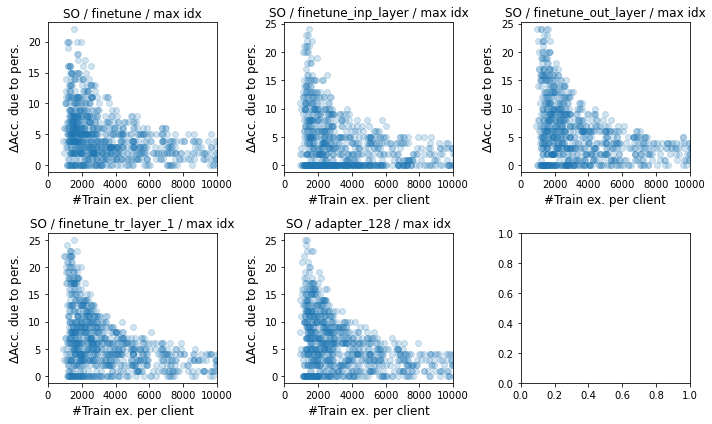

In [71]:
f, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.reshape(-1)
for i, (param, out) in enumerate(zip(param_list, out_list)):
    if out is None:
        print('No output found for', param)
    else:
        make_best_iter_scatter(out, ax[i], param, 'SO')

plt.tight_layout()

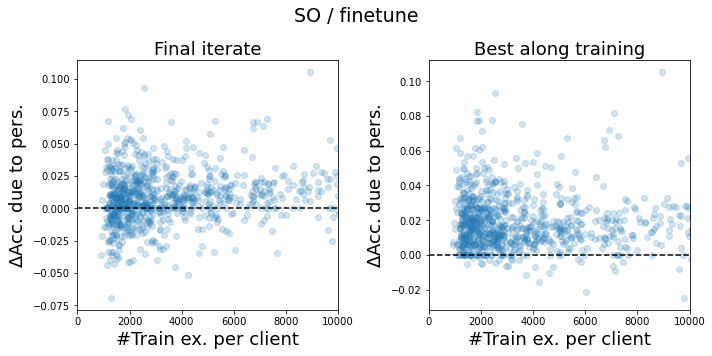

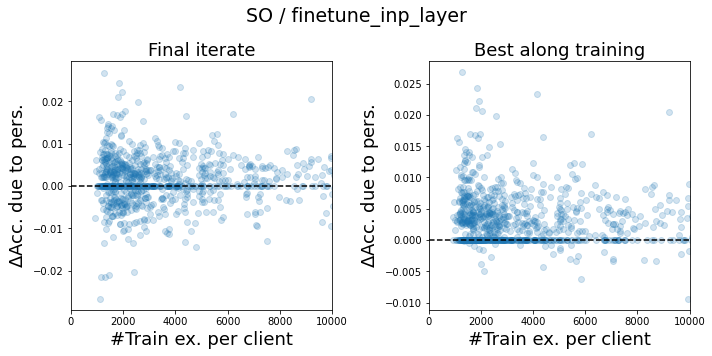

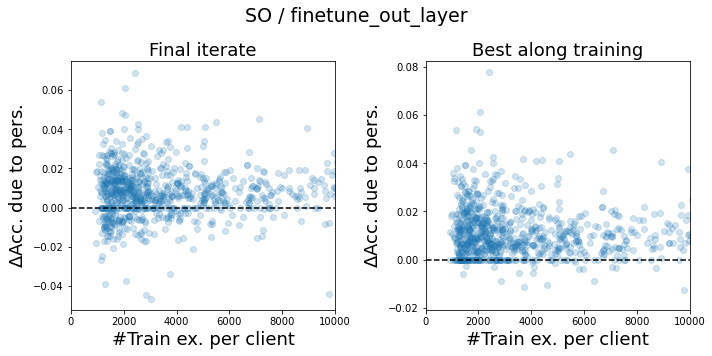

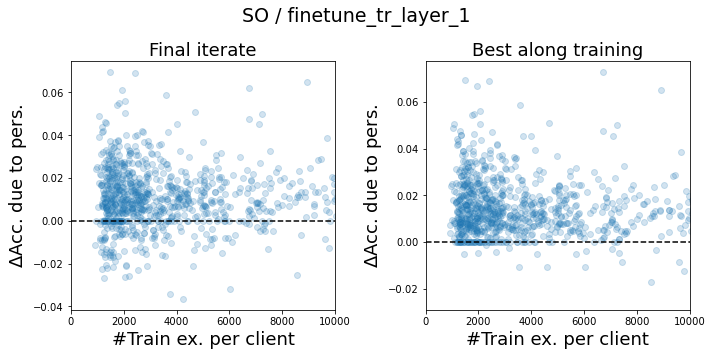

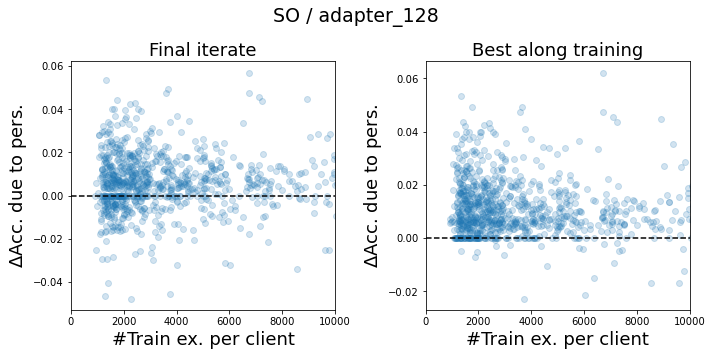

In [54]:
for param, out in zip(param_list, out_list):
    if out is None:
        print('No output found for', param)
    else:
        make_pers_scatter(out, param, 'SO')

In [72]:
param_list = [
    "finetune", "finetune_out_layer",
     "finetune_res_layer_3+4", "adapter"
]

fn = os.path.join(output_dir, "emnist_{}_all.p")

out_list = []

for param in param_list:
    out = load_pkl(fn.format(param))
    out_list.append(out)
    
    
    

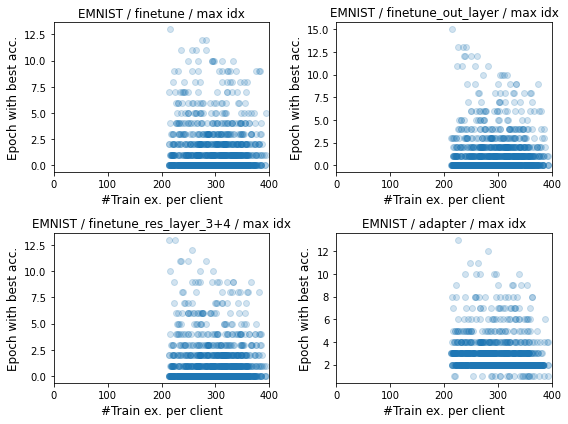

In [78]:
f, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.reshape(-1)
for i, (param, out) in enumerate(zip(param_list, out_list)):
    if out is None:
        print('No output found for', param)
    else:
        make_best_iter_scatter(out, ax[i], param, 'EMNIST')

plt.tight_layout()

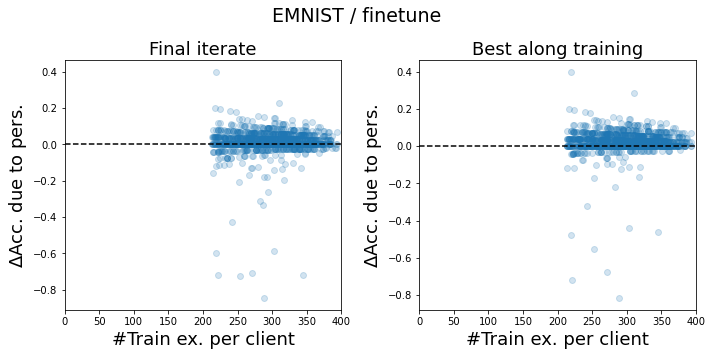

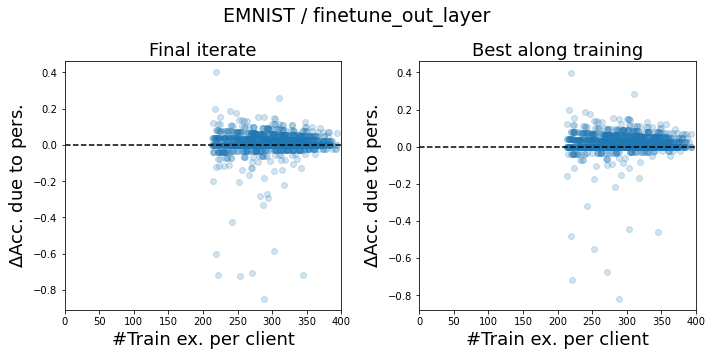

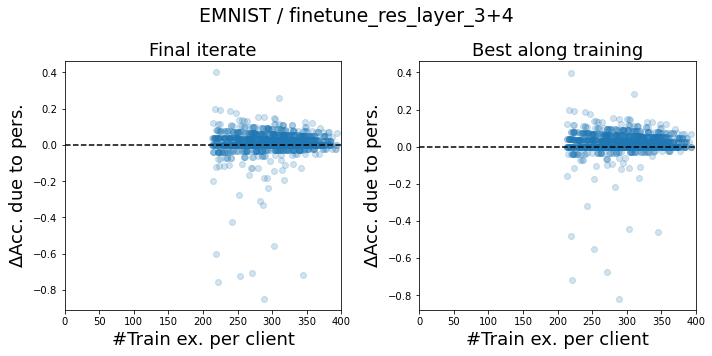

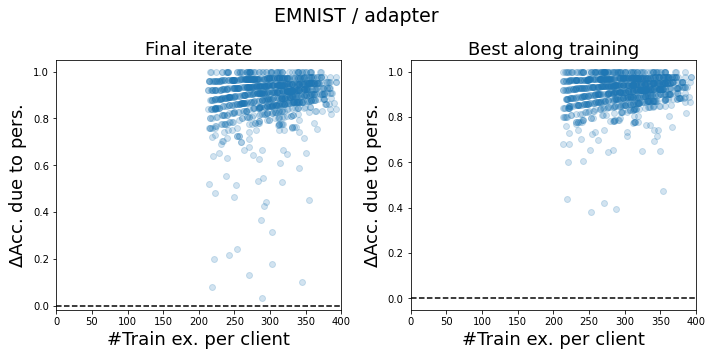

In [61]:
for param, out in zip(param_list, out_list):
    if out is None:
        print('No output found for', param)
    else:
        make_pers_scatter(out, param, 'EMNIST')

# Centralized training: Stack Overflow

In [3]:
df_lst = []
param_list = ['tiny', 'mini', 'medium', 'base']

fn = 'so_{}_try1_{}.csv'
for p in param_list:
    for t in ['train', 'test']:
        df_lst.append(pd.read_csv(os.path.join(output_dir, fn.format(p, t))))

df_tr = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 0]
df_te = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 1]

# df_tr.append(pd.read_csv(os.path.join(output_dir, fn1.format('train'))))
# df_te.append(pd.read_csv(os.path.join(output_dir, fn1.format('test'))))
# df_tr.append(pd.read_csv(os.path.join(output_dir, fn2.format('train'))))
# df_te.append(pd.read_csv(os.path.join(output_dir, fn2.format('test'))))

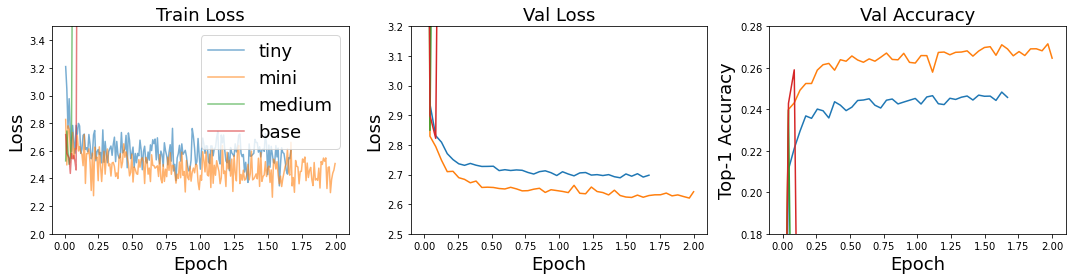

In [4]:
f, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, (do, df) in enumerate(zip(param_list, df_tr)):
    ax[0].plot(df['epoch'], df['avg_loss'], alpha=0.6, color=COLORS[i], label=do)

for param, df in zip(param_list, df_te):
    ax[1].plot(df['epoch'], df['loss|mean'], label=param)
    ax[2].plot(df['epoch'], df['accuracy_top1|mean'], label=param)

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Val Loss', fontsize=18)
ax[2].set_title("Val Accuracy", fontsize=18)
for a in ax:
    a.set_xlabel('Epoch', fontsize=18)
    a.set_ylabel('Loss', fontsize=18)   
ax[2].set_ylabel("Top-1 Accuracy", fontsize=18)

ax[0].legend(fontsize=18)
ax[0].set_ylim((2, 3.5))
ax[1].set_ylim((2.5, 3.2))
ax[2].set_ylim((0.18, 0.28))

plt.tight_layout()

## EMNIST

In [31]:
df_lst = []

import itertools
# param_list = list(itertools.product(['2e-2', '1e-2', '5e-3', '2.5e-3', '1e-3'], [1114, 2228, 3342, 4456]))
param_list = [('2e-2', 2228), ('1e-2', 3342), ('5e-3', 3342)]
# param_list = list(itertools.product(['5e-3'], [1114, 2228, 3342, 4456]))

fn = 'emnist_resnet_lr{}_lre{}_{}.csv'
for p in param_list:
    for t in ['train', 'test']:
        df_lst.append(pd.read_csv(os.path.join(output_dir, fn.format(p[0], p[1], t))))

df_tr = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 0]
df_te = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 1]

# df_tr.append(pd.read_csv(os.path.join(output_dir, fn1.format('train'))))
# df_te.append(pd.read_csv(os.path.join(output_dir, fn1.format('test'))))
# df_tr.append(pd.read_csv(os.path.join(output_dir, fn2.format('train'))))
# df_te.append(pd.read_csv(os.path.join(output_dir, fn2.format('test'))))

In [32]:
for p, df in zip(param_list, df_te):
    print(p, df['accuracy|mean'].to_numpy()[-5:].mean())

('2e-2', 2228) 0.9071895079192999
('1e-2', 3342) 0.9091673497448373
('5e-3', 3342) 0.9100134852851742


('2e-2', 2228) (100, 4)
('1e-2', 3342) (100, 4)
('5e-3', 3342) (100, 4)


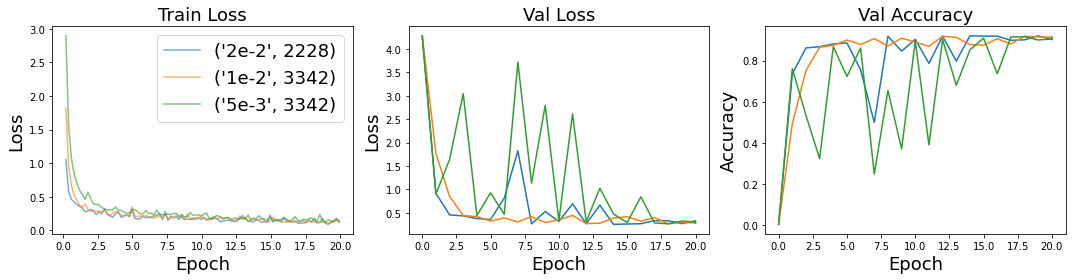

In [33]:
f, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, (p, df) in enumerate(zip(param_list, df_tr)):
    print(p, df.shape)
    ax[0].plot(df['epoch'], df['avg_loss'], alpha=0.6, label=p)

for param, df in zip(param_list, df_te):
    ax[1].plot(df['epoch'], df['loss|mean'], label=param)
    ax[2].plot(df['epoch'], df['accuracy|mean'], label=param)

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Val Loss', fontsize=18)
ax[2].set_title("Val Accuracy", fontsize=18)
for a in ax:
    a.set_xlabel('Epoch', fontsize=18)
    a.set_ylabel('Loss', fontsize=18)   
ax[2].set_ylabel("Accuracy", fontsize=18)

ax[0].legend(fontsize=18)
# ax[0].set_ylim((2, 3.5))
# ax[1].set_ylim((2.5, 3.2))
# ax[2].set_ylim((0.18, 0.28))

plt.tight_layout()

# Emnist LR fed

In [9]:
df_lst = []

import itertools
param_list = [('0.5', 1000), ('0.5', 500)]
# param_list = [('0.1', 500), ('0.2', 500), ('0.5', 500), ('1.0', 500)]
# param_list = [('0.1', 1000), ('0.2', 1000), ('0.5', 1000), ('1.0', 1000)]
# param_list = [('1e-2', 500), ('1e-2', 250), ('1e-2', 125)]
# param_list = [('2.5e-3', 500), ('2.5e-3', 250), ('2.5e-3', 125)]


fn = 'emnist_resnetgn_s-sgd_lr{}_lre{}_{}.csv'
for p in param_list:
    for t in ['train', 'test']:
        df_lst.append(pd.read_csv(os.path.join(output_dir_fed, fn.format(p[0], p[1], t))))

df_tr = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 0]
df_te = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 1]

# df_tr.append(pd.read_csv(os.path.join(output_dir, fn1.format('train'))))
# df_te.append(pd.read_csv(os.path.join(output_dir, fn1.format('test'))))
# df_tr.append(pd.read_csv(os.path.join(output_dir, fn2.format('train'))))
# df_te.append(pd.read_csv(os.path.join(output_dir, fn2.format('test'))))

('0.5', 1000) 0.9334461514053782
('0.5', 500) 0.933631243554827


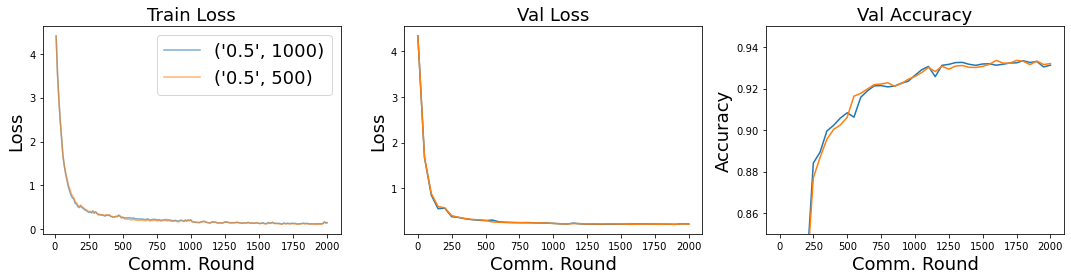

In [10]:
f, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, (p, df) in enumerate(zip(param_list, df_tr)):
    ax[0].plot(df['round'], df['avg_loss'], alpha=0.6, label=p)

for param, df in zip(param_list, df_te):
    print(param, df['accuracy|mean'].max())
    ax[1].plot(df['round'], df['loss|mean'], label=param)
    ax[2].plot(df['round'], df['accuracy|mean'], label=param)

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Val Loss', fontsize=18)
ax[2].set_title("Val Accuracy", fontsize=18)
for a in ax:
    a.set_xlabel('Comm. Round', fontsize=18)
    a.set_ylabel('Loss', fontsize=18)   
ax[2].set_ylabel("Accuracy", fontsize=18)

ax[0].legend(fontsize=18)
# ax[0].set_ylim((2, 3.5))
# ax[1].set_ylim((2.5, 3.2))
ax[2].set_ylim((0.85, 0.95))

plt.tight_layout()

In [11]:
# SO Fed

# SO Federated

In [4]:
df_lst = []

import itertools
param_list = [  ('1e-2', 1), ('1e-2', 10), ('1e-3', 1), ('1e-3', 10)]

arch_size = "tiny"

fn = "so_tiny_c-sgd_s-adam_g-linear_lr{}_slr{}_{}.csv"
for p in param_list:
    for t in ['train', 'test']:
        df_lst.append(pd.read_csv(os.path.join(output_dir_fed, fn.format(p[1], p[0], t))))

df_tr = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 0]
df_te = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 1]


('1e-2', 1) 0.2141542320425598
('1e-2', 10) 0.2170400987128225
('1e-3', 1) 0.2043975753325826
('1e-3', 10) 0.2063596949611958


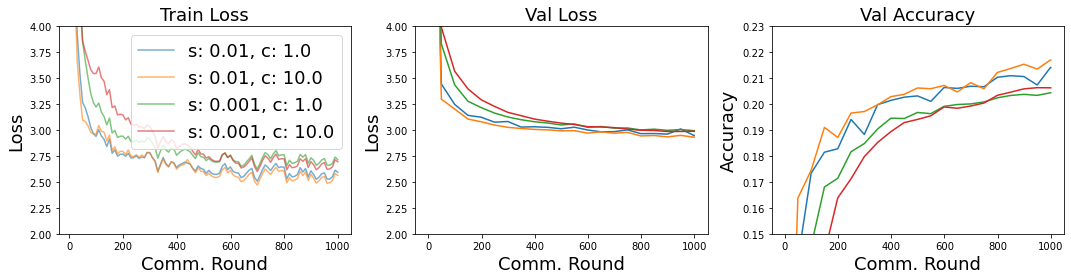

In [5]:
f, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, (p, df) in enumerate(zip(param_list, df_tr)):
    ax[0].plot(df['round'], df['avg_loss'], alpha=0.6, label=f's: {float(p[0])}, c: {float(p[1])}')

for param, df in zip(param_list, df_te):
    print(param, df['accuracy|mean'].max())
    ax[1].plot(df['round'], df['loss|mean'], label=param)
    ax[2].plot(df['round'], df['accuracy|mean'], label=param)

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Val Loss', fontsize=18)
ax[2].set_title("Val Accuracy", fontsize=18)
for a in ax:
    a.set_xlabel('Comm. Round', fontsize=18)
    a.set_ylabel('Loss', fontsize=18)   
ax[2].set_ylabel("Accuracy", fontsize=18)

ax[0].legend(fontsize=18)
ax[0].set_ylim((2, 4))
ax[1].set_ylim((2, 4))
ax[2].set_ylim((0.15, 0.23))

plt.tight_layout()

In [15]:
df_lst = []

import itertools
param_list = ['c: sgd, s: adam', 'c: adam, s: sgd', 'c: adam, s: sgd+m', 'c: adam, s: adam', 'c: sgd, s: sgd+m']
fn_list = [
    "so_tiny_c-sgd_s-adam_g-linear_lr10_slr1e-2_{}.csv",
    "so_tiny_c-adam_s-sgd_g-const_lr3.5e-4_{}.csv",
    "so_tiny_c-adam_s-mom_g-const_lr1e-4_{}.csv",
    "so_tiny_c-adam_s-adam_g-linear_lr3.5e-4_slr1e-3_{}.csv",
    "so_tiny_c-sgd_s-mom_g-linear_lr10_{}.csv"
]

arch_size = "tiny"

for p, fn in zip(param_list, fn_list):
    for t in ['train', 'test']:
        df_lst.append(pd.read_csv(os.path.join(output_dir_fed, fn.format(t))))

df_tr = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 0]
df_te = np.asarray(df_lst, dtype=np.object).reshape(-1, 2)[:, 1]


c: sgd, s: adam 0.2170400987128225
c: adam, s: sgd 0.1652967790221766
c: adam, s: sgd+m 0.1393104936315395
c: adam, s: adam 0.1776763379161076
c: sgd, s: sgd+m 0.2110188862442603


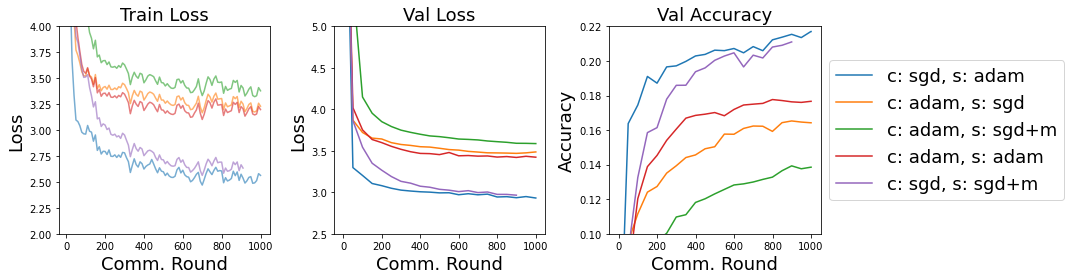

In [16]:
f, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, (p, df) in enumerate(zip(param_list, df_tr)):
    ax[0].plot(df['round'], df['avg_loss'], alpha=0.6, label=p)

for param, df in zip(param_list, df_te):
    print(param, df['accuracy|mean'].max())
    ax[1].plot(df['round'], df['loss|mean'], label=param)
    ax[2].plot(df['round'], df['accuracy|mean'], label=param)

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Val Loss', fontsize=18)
ax[2].set_title("Val Accuracy", fontsize=18)
for a in ax:
    a.set_xlabel('Comm. Round', fontsize=18)
    a.set_ylabel('Loss', fontsize=18)   
ax[2].set_ylabel("Accuracy", fontsize=18)

# ax[0].legend(fontsize=18)
ax[0].set_ylim((2, 4))
ax[1].set_ylim((2.5, 5))
ax[2].set_ylim((0.10, 0.22))

ax[-1].legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=18)

plt.tight_layout()